In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import anndata as ad
import random
import jax.numpy as jnp 
import itertools
# import spatialscvi as chvae
import chvae 
import scvi
import matplotlib.pyplot as plt
import pandas as pd
# import pertpy

scvi.settings.dl_num_workers = 0
scvi.settings.seed = 0
from scib_metrics.benchmark import Benchmarker
import scib_metrics

%matplotlib inline
%load_ext autoreload
%autoreload 2

Seed set to 0


In [2]:
adata = sc.read_10x_mtx("simulation_data/simulation1")
meta = pd.read_csv("simulation_data/simulation1_meta.csv", index_col = 0)
adata.obs = meta

In [3]:
adatas = adata.copy()
adata.layers["counts"] = adata.X.copy()

In [4]:
group_mapping = {
    'B cells': 'Group A',
    'CD4 T cells': 'Group A',
    'CD14+ Monocytes': 'Group A',
    'CD8 T cells': 'Group B',
    'Dendritic cells': 'Group C',
    'FCGR3A+ Monocytes': 'Group D'
}

celltype_mapping = {
    'B cells': 'Celltype A',
    'CD4 T cells': 'Celltype B',
    'CD14+ Monocytes': 'Celltype C',
    'CD8 T cells': 'Celltype D',
    'Dendritic cells': 'Celltype E',
    'FCGR3A+ Monocytes': 'Celltype F'
}

treatment_mapping = {
    "Group1": "WT",
    "Group2": "KO"
}
    


# Applying the mapping to create a new column
adata.obs['group'] = adata.obs['celltype'].map(group_mapping)
adata.obs['celltype'] = adata.obs['celltype'].map(celltype_mapping)
adata.obs['treatment'] = adata.obs['Group'].map(treatment_mapping)

In [5]:
# sc.pp.normalize_total(adata)
# sc.pp.log1p(adata)
# sc.pp.scale(adata)
# sc.pp.pca(adata)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)
# sc.pl.umap(adata, color = ['group', "celltype", "treatment"])

In [6]:
adata.obs['treat'] = np.where(adata.obs['Group'] == "Group1", 0, 1)

In [10]:
chvae.model.JaxSCVI

chvae.model.JaxSCVI

In [12]:
layers = [1, 3, 5]
for layer in layers:
    chvae.model.JaxSCVI.setup_anndata(adata, design=["treat"], layer="counts")
    model = chvae.model.JaxSCVI(adata, gene_likelihood="nb", n_layer = layer)
    model.train(accelerator='gpu', max_epochs = 400)
    adata.obsm[f"X_hvi_bg{layer}"] = model.get_latent_representation(layer = -2
    )
    adata.obsm[f"X_hvi_salient{layer}"] = model.get_latent_representation(
    )

INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


/home/chengwei/miniconda3/envs/sc/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/chengwei/miniconda3/envs/sc/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/chengwei/miniconda3/envs/sc/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/home/chengwei/miniconda3/envs/sc/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:385: You have overridden `transfer_batch_to_device` in `LightningModule` but have passed in a `LightningDataModule`. It will use the implementation from `LightningModule` instance.


In [8]:
scvi.external.ContrastiveVI.setup_anndata(adata, layer="counts")
contrastive_vi_model = scvi.external.ContrastiveVI(
    adata
)
background_indices = np.where(adata.obs["treat"] == 0)[0]
target_indices = np.where(adata.obs["treat"] != 0)[0]
contrastive_vi_model.train(
    background_indices=background_indices,
    target_indices=target_indices,
    # early_stopping=True,
    # max_epochs=500,
)
adata.obsm["X_cvi_salient"] = contrastive_vi_model.get_latent_representation(
    adata, representation_kind = "salient"
)
adata.obsm["X_cvi_bg"] = contrastive_vi_model.get_latent_representation(
    adata, representation_kind = "background"
)

/home/chengwei/miniconda3/envs/jax/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/chengwei/miniconda3/envs/jax/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████████████████████████████████████████████████| 400/400 [02:24<00:00,  1.86it/s, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=1.68e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████████████████████████████████████████████████| 400/400 [02:24<00:00,  2.76it/s, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=1.68e+3]


In [9]:
def cluster_small_multiples(adata, clust_key, size=60, frameon=False, legend_loc=None, **kwargs):
    tmp = adata.copy()

    for i,clust in enumerate(adata.obs[clust_key].cat.categories):
        tmp.obs[clust] = adata.obs[clust_key].isin([clust]).astype('category')
        tmp.uns[clust+'_colors'] = ['#d3d3d3', adata.uns[clust_key+'_colors'][i]]
    # sc.pl.embedding(tmp, groups=tmp.obs[clust].cat.categories[1:].values, color=adata.obs[clust_key].cat.categories.tolist(), size=size, frameon=frameon, legend_loc=legend_loc, **kwargs, basis = "X_hvi_salient")
    sc.pl.umap(tmp, groups=tmp.obs[clust].cat.categories[1:].values, color=adata.obs[clust_key].cat.categories.tolist(), size=size, frameon=frameon, legend_loc=legend_loc, **kwargs)

In [10]:
def cal_umap(adata, use_rep):
    sc.pp.neighbors(adata, use_rep = use_rep)
    sc.tl.umap(adata)
    adata.obsm[use_rep + "_umap"] = adata.obsm["X_umap"]
    del adata.obsm["X_umap"]

In [11]:
adata_reps = ["X_hvi_bg1", "X_hvi_bg3", "X_hvi_bg5", "X_cvi_bg"]
for adata_rep in adata_reps:
    cal_umap(adata, adata_rep)

In [12]:
target_adata = adata[adata.obs.treat == 1]
target_adata_reps = ["X_hvi_salient1", "X_hvi_salient3", "X_hvi_salient5", "X_cvi_salient"]
for target_adata_rep in target_adata_reps:
    cal_umap(target_adata, target_adata_rep)

In [13]:
bm = Benchmarker(
    adata,
    batch_key="Group",
    label_key="celltype",
    embedding_obsm_keys=adata_reps,
    n_jobs=-1,
)
bm.benchmark()

/home/chengwei/miniconda3/envs/jax/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
Metrics:   0%|                                                                                                                                   | 0/10 [00:00<?, ?it/s]
                                                                                                                                                                        
Metrics:   0%|                                                                                                                                   | 0/10 [00:00<?, ?it/s]
                                                                                                                                        

In [ ]:
bm1 = Benchmarker(
    target_adata,
    batch_key="celltype",
    label_key="group",
    embedding_obsm_keys=target_adata_reps,
    n_jobs=-1,
)
bm1.benchmark()

In [47]:
bm.get_results(min_max_scale = False)

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,,,,
X_hvi_bg1,0.654791,0.896562,0.771505,0.654791,1.0,0.948739,0.845256,0.775333,0.996333,0.917301,0.896593,0.79553,0.835955
X_hvi_bg3,0.770712,1.0,1.0,0.770712,1.0,0.958305,0.883106,0.840333,0.996667,0.913965,0.918475,0.908285,0.912361
X_hvi_bg5,0.773542,1.0,1.0,0.773542,1.0,0.960577,0.880429,0.896667,0.996,0.940715,0.934877,0.909417,0.919601
X_cvi_bg,0.66571,1.0,1.0,0.66571,1.0,0.912298,0.815638,0.72,0.991333,0.933178,0.87449,0.866284,0.869566
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


In [15]:
bm1.get_results(min_max_scale = False)

,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,,,,
X_hvi_salient1,0.675508,0.797522,0.750906,0.621625,0.991953,0.845534,0.035142,0.013298,0.992634,0.049859,0.387293,0.767503,0.615419
X_hvi_salient3,0.665059,0.750879,0.66185,0.611676,0.976853,0.88904,0.121545,0.139628,0.993286,0.158717,0.460443,0.733263,0.624135
X_hvi_salient5,0.666139,0.663465,0.509814,0.600729,0.967216,0.873921,0.101626,0.033245,0.99284,0.106221,0.42157,0.681473,0.577512
X_cvi_salient,0.58858,0.543069,0.376587,0.546737,0.887287,0.898395,0.17313,0.089096,0.962517,0.549255,0.534479,0.588452,0.566863
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


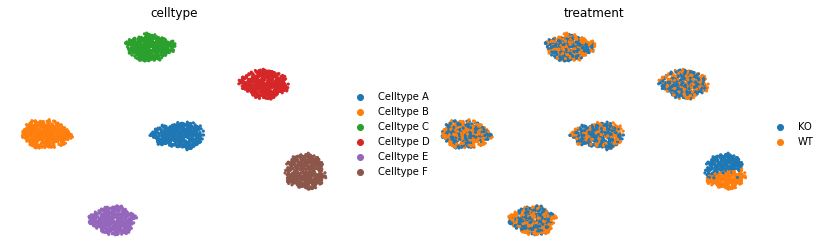

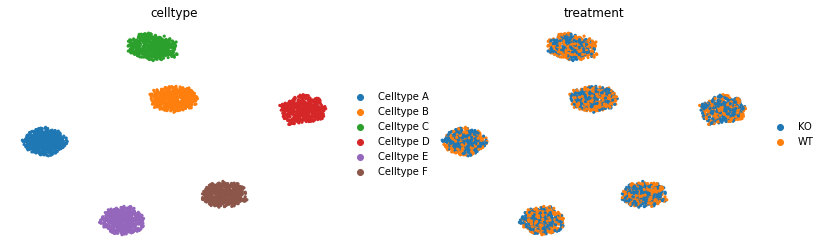

In [22]:
sc.pl.embedding(adata, basis = "X_cvi_bg_umap", color = ["celltype", "treatment"], frameon  = False)
sc.pl.embedding(adata, basis = "X_hvi_bg3_umap", color = ["celltype", "treatment"], frameon = False)

In [39]:
adata.X = adata.layers["counts"].copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/chengwei/miniconda3/envs/jax/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<Axes: title={'center': 'CHVAE (L=3) salient'}, xlabel='X_hvi_salient3_umap1', ylabel='X_hvi_salient3_umap2'>

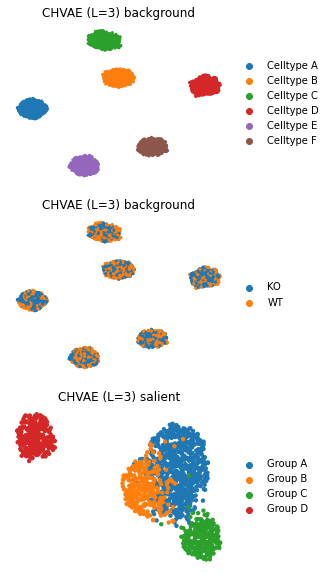

In [45]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(4, 10))

sc.pl.embedding(adata, basis = "X_hvi_bg3_umap", color = ["celltype"], ax = ax1, show = False, frameon = False, title = "CHVAE (L=3) background")
sc.pl.embedding(adata, basis = "X_hvi_bg3_umap", color = ["treatment"], ax = ax2, show = False, frameon = False, title = "CHVAE (L=3) background")
sc.pl.embedding(target_adata, basis = "X_hvi_salient3_umap", color = ["group"], ax = ax3, show = False, frameon = False, title = "CHVAE (L=3) salient")

In [46]:
fig.figure.savefig("figures/simulation1_chvae.pdf", bbox_inches = 'tight')

<Axes: title={'center': 'ContrastiveVI salient'}, xlabel='X_cvi_salient_umap1', ylabel='X_cvi_salient_umap2'>

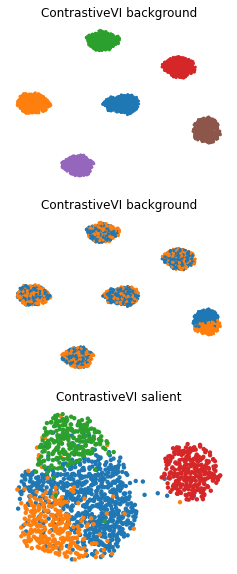

In [43]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(4, 10))

sc.pl.embedding(adata, basis = "X_cvi_bg_umap", color = ["celltype"], ax = ax1, show = False, frameon = False, title = "ContrastiveVI background", legend_loc = None)
sc.pl.embedding(adata, basis = "X_cvi_bg_umap", color = ["treatment"], ax = ax2, show = False, frameon = False, title = "ContrastiveVI background", legend_loc = None)
sc.pl.embedding(target_adata, basis = "X_cvi_salient_umap", color = ["group"], ax = ax3, show = False, frameon = False, title = "ContrastiveVI salient", legend_loc = None)

In [44]:
fig.figure.savefig("figures/simulation1_cvi.pdf", bbox_inches = 'tight')

<Axes: title={'center': 'PCA'}, xlabel='X_umap1', ylabel='X_umap2'>

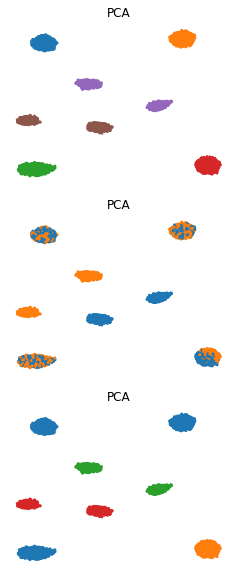

In [41]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(4, 10))

sc.pl.embedding(adata, basis = "X_umap", color = ["celltype"], ax = ax1, show = False, frameon = False, title = "PCA", legend_loc = None)
sc.pl.embedding(adata, basis = "X_umap", color = ["treatment"], ax = ax2, show = False, frameon = False, title = "PCA", legend_loc = None)
sc.pl.embedding(adata, basis = "X_umap", color = ["group"], ax = ax3, show = False, frameon = False, title = "PCA", legend_loc = None)

In [42]:
fig.figure.savefig("figures/simulation1_pca.pdf", bbox_inches = 'tight')

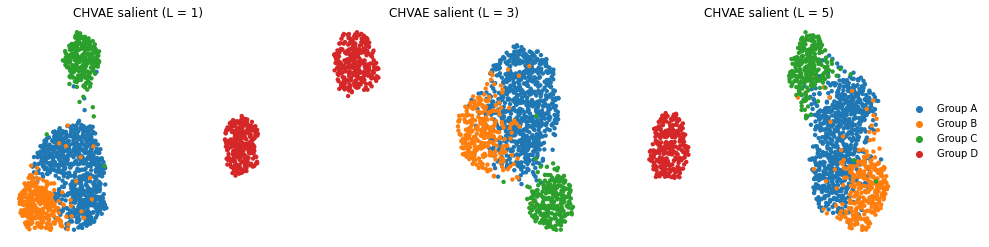

In [56]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

sc.pl.embedding(target_adata, basis = "X_hvi_salient1_umap", color = ["group"], ax = ax1, show = False, frameon = False, title = "CHVAE salient (L = 1)", legend_loc = None)
sc.pl.embedding(target_adata, basis = "X_hvi_salient3_umap", color = ["group"], ax = ax2, show = False, frameon = False, title = "CHVAE salient (L = 3)", legend_loc = None)
sc.pl.embedding(target_adata, basis = "X_hvi_salient5_umap", color = ["group"], ax = ax3, show = False, frameon = False, title = "CHVAE salient (L = 5)")
fig.figure.savefig("figures/simulation1_layers.pdf", bbox_inches = 'tight')